# Graph Neural Networks to Predict Missing Virus-Host Links

In [1]:
import os
import pandas as pd
import torch

from torch_geometric import seed_everything
seed_everything(12345)

## Mammalian Data from Divide & Conquer

In [2]:
host_features_path = os.path.join('..', '..', 'data', 'divide_and_conqour', 'final_mammal_features.csv')
viral_features_path = os.path.join('..', '..', 'data', 'divide_and_conqour', 'final_virus_features.csv')
interactions_path = os.path.join('..', '..', 'data', 'divide_and_conqour', 'final_interactions.csv')

host_feats = pd.read_csv(host_features_path)
viral_feats = pd.read_csv(viral_features_path)
interactions = pd.read_csv(interactions_path)

This implementation is informed by the following PyG [tutorial](https://medium.com/@pytorch_geometric/link-prediction-on-heterogeneous-graphs-with-pyg-6d5c29677c70). The pathogen and host ID values uniquely identify the entities in our study, but they're also massive numbers. For data compactness, we will create a mapping from those to consecutive values in the range [0, num_entries].

In [3]:
unique_host_ids = host_feats['hostid'].unique()
host_id_mapping = pd.DataFrame(data={
    'hostID': unique_host_ids,
    'mappedID': pd.RangeIndex(len(unique_host_ids))
})
print("Head of the host id mapping DF:\n", host_id_mapping.head())

unique_virus_ids = viral_feats['pathogenid'].unique()
virus_id_mapping = pd.DataFrame(data={
    'virusID': unique_virus_ids,
    'mappedID': pd.RangeIndex(len(unique_virus_ids))
})
print("\nHead of the virus id mapping DF:\n", virus_id_mapping.head())

Head of the host id mapping DF:
     hostID  mappedID
0  3433010         0
1  3433020         1
2  3433026         2
3  3433081         3
4  3433091         4

Head of the virus id mapping DF:
    virusID  mappedID
0  1195280         0
1  1195281         1
2  1195282         2
3  1195283         3
4  1195284         4


Now for interactions, we will create a torch matrix of shape ```(2, num_interactions)```. To do this, we will first use merges to get the corresponding mappedIDs.

In [4]:
interactions_host_ids = pd.merge(interactions['hostID'], host_id_mapping, left_on='hostID', right_on='hostID', how='left')
interactions_host_ids = torch.from_numpy(interactions_host_ids['mappedID'].values)

interactions_virus_ids = pd.merge(interactions['pathogenID'], virus_id_mapping, left_on='pathogenID', right_on='virusID', how='left')
interactions_virus_ids = torch.from_numpy(interactions_virus_ids['mappedID'].values)

edge_index_virus_to_host = torch.stack([interactions_virus_ids, interactions_host_ids], dim=0)
print(edge_index_virus_to_host.shape)

torch.Size([2, 6192])


PyG's tutorial for link prediction on heterogenous graphs recommends using their ```HeteroData``` object instead of a traditional Torch ```Dataset```.

In [5]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

device = 'cuda' if torch.cuda.is_available() else 'cpu'

data = HeteroData()

# For each class, store the node ids and the features. Features will be of shape (# nodes, # features)
data['virus'].node_id = torch.arange(len(unique_virus_ids))
# NOTE: this data doesn't have a one-hot encoding for the taxonomy. Could maybe capture this with get_dummies()
# problem is, there are like more than a 1000 of these.
data['virus'].x = torch.from_numpy(viral_feats.drop(columns=['pathogenid', 'ncbi.name']).values).to(torch.float)

# TODO: will need to go back and make both one-hot and ordinal versions of this data for the horder and hfamily features
# That will add another 124 columns if one-hot encoded.  
# TODO: Will also need to come back and deal with the 'status' feature. It says whether the animal is wild or domesticated
# didn't realize that this wasn't already encoded better
data['host'].node_id = torch.arange(len(unique_host_ids))
data['host'].x = torch.from_numpy(host_feats.drop(columns=['hostid', 'host', 'horder', 'hfamily', 'status']).values).to(torch.float)

# Add the edges
data['virus', 'infects', 'host'].edge_index = edge_index_virus_to_host

data = T.ToUndirected()(data)  # Add the reverse edges
print(data)

HeteroData(
  virus={
    node_id=[1885],
    x=[1885, 30],
  },
  host={
    node_id=[1312],
    x=[1312, 63],
  },
  (virus, infects, host)={ edge_index=[2, 6192] },
  (host, rev_infects, virus)={ edge_index=[2, 6192] }
)


In [6]:
split_transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=('virus', 'infects', 'host'),
    rev_edge_types=('host', 'rev_infects', 'virus')
)

train_data, val_data, test_data = split_transform(data)

print('Train Data:')
print(train_data)
print('\nVal Data:')
print(val_data)
print('\nTest Data:')
print(test_data)

Train Data:
HeteroData(
  virus={
    node_id=[1885],
    x=[1885, 30],
  },
  host={
    node_id=[1312],
    x=[1312, 63],
  },
  (virus, infects, host)={
    edge_index=[2, 3468],
    edge_label=[1486],
    edge_label_index=[2, 1486],
  },
  (host, rev_infects, virus)={ edge_index=[2, 3468] }
)

Val Data:
HeteroData(
  virus={
    node_id=[1885],
    x=[1885, 30],
  },
  host={
    node_id=[1312],
    x=[1312, 63],
  },
  (virus, infects, host)={
    edge_index=[2, 4954],
    edge_label=[1857],
    edge_label_index=[2, 1857],
  },
  (host, rev_infects, virus)={ edge_index=[2, 4954] }
)

Test Data:
HeteroData(
  virus={
    node_id=[1885],
    x=[1885, 30],
  },
  host={
    node_id=[1312],
    x=[1312, 63],
  },
  (virus, infects, host)={
    edge_index=[2, 5573],
    edge_label=[1857],
    edge_label_index=[2, 1857],
  },
  (host, rev_infects, virus)={ edge_index=[2, 5573] }
)


In [12]:
from torch_geometric.loader import LinkNeighborLoader

# NOTE: Not exactly sure what these two lines are doing - apparently define seed edges???
edge_label_index = train_data['virus', 'infects', 'host'].edge_label_index
edge_label = train_data['virus', 'infects', 'host'].edge_label

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(('virus', 'infects', 'host'), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True
)

print("Example of a training mini-batch:")
print(next(iter(train_loader)))

# Also set up the loader for the validation set so that we can track the performance on that as we go
edge_label_index_val = val_data['virus', 'infects', 'host'].edge_label_index
edge_label_val = val_data['virus', 'infects', 'host'].edge_label
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(('virus', 'infects', 'host'), edge_label_index_val),
    edge_label=edge_label_val,
    batch_size=128,
    shuffle=True
)
print("\nExample of a validation mini-batch:")
print(next(iter(val_loader)))

Example of a training mini-batch:
HeteroData(
  virus={
    node_id=[987],
    x=[987, 30],
    n_id=[987],
    num_sampled_nodes=[3],
  },
  host={
    node_id=[738],
    x=[738, 63],
    n_id=[738],
    num_sampled_nodes=[3],
  },
  (virus, infects, host)={
    edge_index=[2, 2316],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[2316],
    num_sampled_edges=[2],
    input_id=[128],
  },
  (host, rev_infects, virus)={
    edge_index=[2, 2188],
    e_id=[2188],
    num_sampled_edges=[2],
  }
)

Example of a validation mini-batch:
HeteroData(
  virus={
    node_id=[758],
    x=[758, 30],
    n_id=[758],
    num_sampled_nodes=[3],
  },
  host={
    node_id=[620],
    x=[620, 63],
    n_id=[620],
    num_sampled_nodes=[3],
  },
  (virus, infects, host)={
    edge_index=[2, 1772],
    edge_label=[128],
    edge_label_index=[2, 128],
    e_id=[1772],
    num_sampled_edges=[2],
    input_id=[128],
  },
  (host, rev_infects, virus)={
    edge_index=[2, 1719],
    e_id=[1719],


In [24]:
from models.standard import StandardModel

# For the mammalian data, the number of features is like 30 and 60.
model = StandardModel(hidden_channels=64, metadata=data.metadata())
print(model)

StandardModel(
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (virus__infects__host): SAGEConv((-1, -1), 64, aggr=mean)
      (host__rev_infects__virus): SAGEConv((-1, -1), 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (virus__infects__host): SAGEConv(64, 64, aggr=mean)
      (host__rev_infects__virus): SAGEConv(64, 64, aggr=mean)
    )
    (conv3): ModuleDict(
      (virus__infects__host): SAGEConv(64, 64, aggr=mean)
      (host__rev_infects__virus): SAGEConv(64, 64, aggr=mean)
    )
    (conv4): ModuleDict(
      (virus__infects__host): SAGEConv(64, 64, aggr=mean)
      (host__rev_infects__virus): SAGEConv(64, 64, aggr=mean)
    )
    (conv5): ModuleDict(
      (virus__infects__host): SAGEConv(64, 64, aggr=mean)
      (host__rev_infects__virus): SAGEConv(64, 64, aggr=mean)
    )
    (conv6): ModuleDict(
      (virus__infects__host): SAGEConv(64, 64, aggr=mean)
      (host__rev_infects__virus): SAGEConv(64, 64, aggr=mean)
    )
    (conv7): ModuleDict(
      (virus__infect

In [25]:
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

print('Selected device: ', device)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss_hist = []
val_loss_hist = []
for epoch in range(10):
    epoch_loss = epoch_size = 0

    model.train()
    for sampled_data in tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data = sampled_data.to(device)
        pred = model(sampled_data)
        
        labels = sampled_data['virus', 'infects', 'host'].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, labels)
        
        loss.backward()
        optimizer.step()

        epoch_loss += float(loss) * pred.numel()  # Default reduction is mean so multiplying by num elements recovers sum
        epoch_size += pred.numel()

    if epoch % 1 == 0:  # This is to control how often we validate. For now do every epoch since num epochs is low
        # NOTE: for now I'm just using AUROC since it's standard, but we should be using AUCPR instead 
        model.eval()
        val_preds = []
        val_labels = []
        for sampled_data in tqdm(val_loader):
            with torch.no_grad():
                sampled_data = sampled_data.to(device)
                val_preds.append(model(sampled_data))
                val_labels.append(sampled_data['virus', 'infects', 'host'].edge_label)
            
        val_preds = torch.cat(val_preds, dim=0)
        val_labels = torch.cat(val_labels, dim=0)
        val_loss = F.binary_cross_entropy_with_logits(val_preds, val_labels).cpu().item()
        val_loss_hist.append(val_loss)
        auroc = roc_auc_score(val_labels.cpu().numpy(), val_preds.cpu().numpy())
    
    print(f'Epoch: {epoch}, Train Loss: {epoch_loss / epoch_size:.4f}, Validation Loss: {val_loss}, AUROC: {auroc}')
    train_loss_hist.append(epoch_loss / epoch_size)

Selected device:  cuda


100%|██████████| 15/15 [00:00<00:00, 107.46it/s]


Epoch: 0, Train Loss: 20030152468846.6016, Validation Loss: 1124146216960.0, AUROC: 0.6334256356988315


100%|██████████| 15/15 [00:00<00:00, 107.51it/s]


Epoch: 1, Train Loss: 490453687184.3661, Validation Loss: 123512954880.0, AUROC: 0.665757997290956


100%|██████████| 15/15 [00:00<00:00, 103.77it/s]


Epoch: 2, Train Loss: 84241166027.2840, Validation Loss: 35078991872.0, AUROC: 0.6864868814936803


100%|██████████| 15/15 [00:00<00:00, 104.14it/s]


Epoch: 3, Train Loss: 32207240320.1723, Validation Loss: 50043678720.0, AUROC: 0.739015714020999


100%|██████████| 15/15 [00:00<00:00, 106.74it/s]


Epoch: 4, Train Loss: 17875734803.6393, Validation Loss: 25446350848.0, AUROC: 0.6799856979181075


100%|██████████| 15/15 [00:00<00:00, 107.50it/s]


Epoch: 5, Train Loss: 17667160117.7497, Validation Loss: 28598003712.0, AUROC: 0.6794311007644305


100%|██████████| 15/15 [00:00<00:00, 107.51it/s]


Epoch: 6, Train Loss: 12164495604.6299, Validation Loss: 11932547072.0, AUROC: 0.7209671652386334


100%|██████████| 15/15 [00:00<00:00, 107.88it/s]


Epoch: 7, Train Loss: 9986930857.5182, Validation Loss: 15526190080.0, AUROC: 0.7202233525854667


100%|██████████| 15/15 [00:00<00:00, 109.07it/s]


Epoch: 8, Train Loss: 7512908363.1117, Validation Loss: 15747150848.0, AUROC: 0.6981386414588123


100%|██████████| 15/15 [00:00<00:00, 105.61it/s]

Epoch: 9, Train Loss: 5854287804.4684, Validation Loss: 10191218688.0, AUROC: 0.7390131041520406


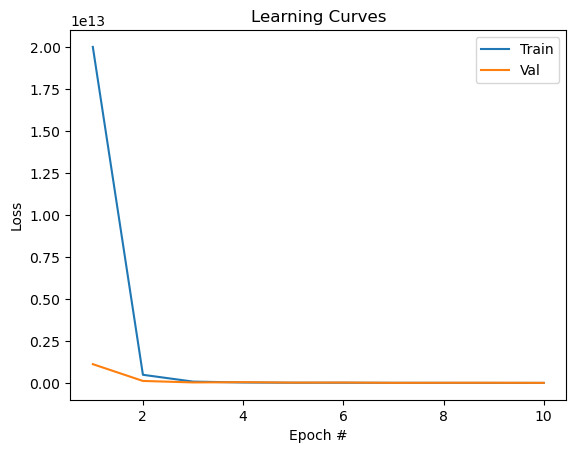

In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.plot(np.arange(1, 11), train_loss_hist, label='Train')
plt.plot(np.arange(1, 11), val_loss_hist, label='Val')
plt.title('Learning Curves')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()
plt.show()

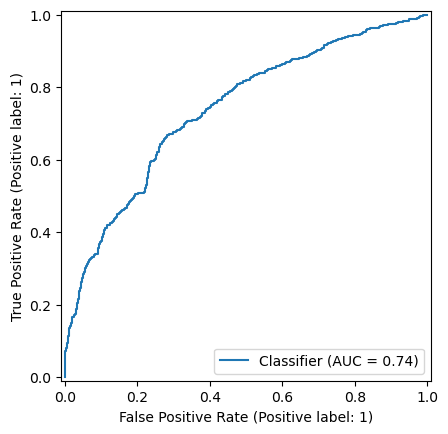

In [30]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(val_labels.cpu().numpy(), val_preds.cpu().numpy())
plt.show()